In [15]:
#importando as bibliotecas que serao utilizadas

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA


In [2]:
#importando o arquivo csv
df = pd.read_csv("https://raw.githubusercontent.com/coinmetrics/data/master/csv/btc.csv")

df.head()

,time,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
0,2009-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# manteremos somente as colunas 'time' e 'PriceUsd' para fazer a predicao
df = df[['time', 'PriceUSD']]
df.dtypes

time         object
PriceUSD    float64
dtype: object

In [4]:
# transformando a coluna 'time' em index para posteriormente plotarmos a serie 'PriceUSD' e usar o dataframe
# diretamente no modelo de autoregressao AutoReg
df.time = pd.to_datetime(df.time)
df.set_index('time', inplace = True)
df.index = pd.DatetimeIndex(df.index).to_period('D')

In [5]:
# verificando a quantidade de valores nulos presentes no dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4912 entries, 2009-01-03 to 2022-06-15
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PriceUSD  4350 non-null   float64
dtypes: float64(1)
memory usage: 76.8 KB


<AxesSubplot:xlabel='time'>

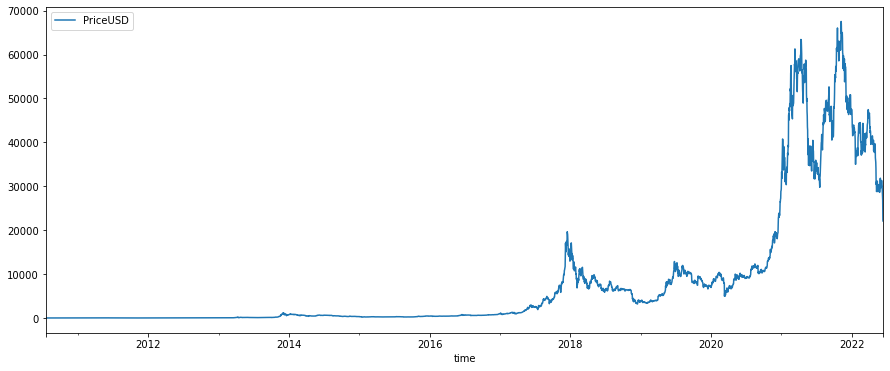

In [6]:
#deletando linhas com valores nulos
df.dropna(inplace = True)

# plot simples dos dados
df.plot(figsize = (15,6))

<AxesSubplot:xlabel='time'>

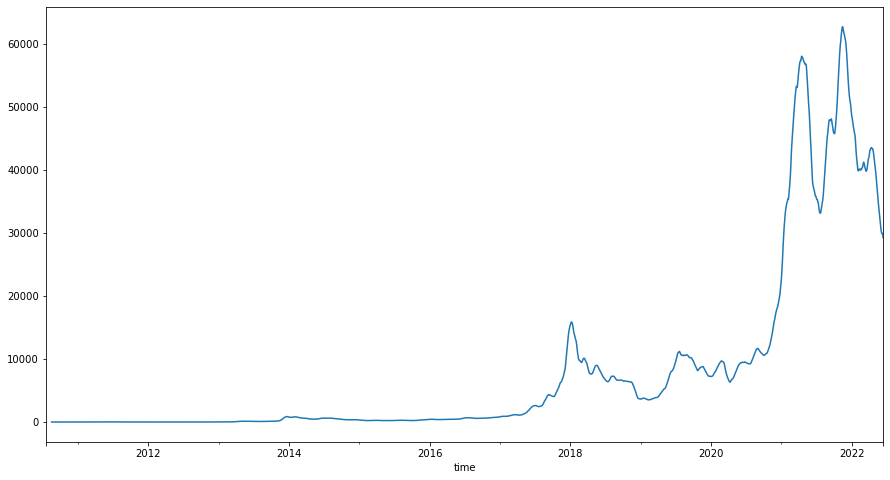

In [7]:
# plot media movel de 30 dias
df.PriceUSD.rolling(30).mean().plot(figsize = (15,8))

In [8]:
# Ajustando modelos AR(p), com p de 1 a 6, para fazer a predição do valor da série no próximo dia. 
# model.resid fornece o erro residual de cada previsão. err_qm é o erro quadrático médio do modelo. 
erro = []
for p in range (1,7):
    model = AutoReg(df, lags = p).fit()
    err_qm = (model.resid**2).mean()
    erro.append([round(err_qm,2)])


C:\Users\luish\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


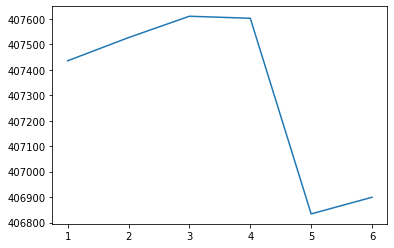

In [9]:
# plot do erro quadratico medio em funcao da ordem p do modelo AR(p). p = 5 obteve o melhor resultado
x = range(1,7)
plt.plot(x, erro);

In [10]:
df.tail()

,PriceUSD
time,
2022-06-10,29070.400030
2022-06-11,28360.789923
2022-06-12,26830.283946
2022-06-13,22316.257040
2022-06-14,22072.866309


In [11]:
# Novamente treinando o modelo agora com i = 5 para fazermos a previsão do dia 15/06/2022.
model = AutoReg(df, lags = 5, trend = 't', seasonal=True ).fit()
model.predict(start = '2022-06-15', end = '2022-06-15')


C:\Users\luish\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


2022-06-15    22070.081078
Freq: D, dtype: float64

Valor previsto com modelo Autoregressivo de ordem 5: BTC = 22070.08 USD

Fiz também testes com valores de máximos de p chegando até 365 e a função de erro apresentou-se praticamente
monotonica decrescente. Entretanto, imagino que tentar prever o preço do Bitcoin utilizando uma autoregressão
que leva em conta muitos dias não seja uma boa ideia, mesmo com o erro quadrático médio ficando menor com o aumento
de p. Imagino que os períodos onde o preço se manteve mais estável (que é a maior parte do tempo) tenham contribuído
significativamente para diminuição do erro conforme aumenta-se p. Como estamos em um momento de variação brusca do 
Bitcoin, imagino que não faça sentido tentar utilizar autoregressões de ordem alta. 

Outra forma de analisar qual a melhor ordem para a autoregressão é a partir dos gráficos de correlação e autocorrelação.


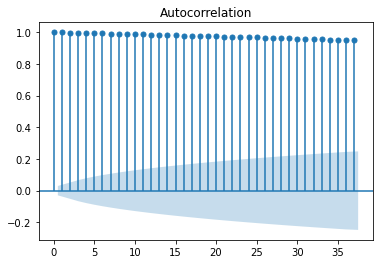

In [12]:
# Gráfico de autocorrelação indicando que há correlação significativa entre o valor atual do bitcoin e os vários lags subsequentes
plot_acf(df)
plt.show()

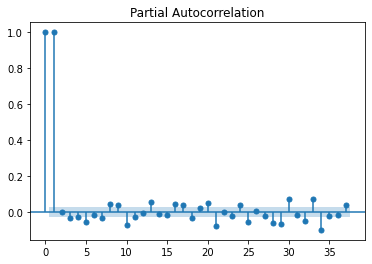

In [21]:
# Gráfico de autocorrelação parcial indicando que a há correação direta muito significativa entre o valor do bitcoin e 
# o lag 1 e algumas outras correlações não tão significativas em lags superiores. Notar que após o lag 1, o lag 5 é o
# próximo lag  sginificativamente correlacionado com o valor atual.

plot_pacf(df)
plt.show()

In [19]:
# Ajustando um modelo ARMA onde serão testados p = [1,4] e q entre 1 e 3.
p = [1,5]
erro = []
for i in p:
    for j in range (1,4):
        arma = ARMA(df, freq = 'D', order = (i, j)).fit();
        err_qm = (arma.resid**2).mean()
        erro.append([i, j, round(err_qm,2)])

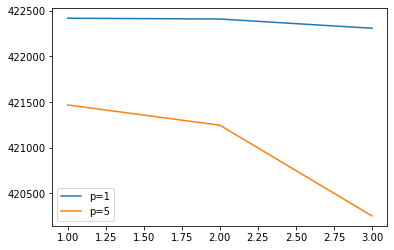

In [20]:
p1 = []
for i in range(3):
    p1.append(erro[i][2])
p5 = []
for i in range(3,6):
    p5.append(erro[i][2])
    
# plot do erro quadratico medio dos modelos ajustados variando-se p e q. O menor erro quadratico medio obtido foi para (p = 5, q = 3)
x = range(1,4)
plt.plot(x, p1, label='p=1')
plt.plot(x, p5, label='p=5')
plt.legend()
plt.show()

In [18]:
# Novamente treinando o modelo agora com (p = 5, q = 3) para fazermos a previsão do dia 15/06/2022.
arma = ARMA(df, freq = 'D', order = (5, 3)).fit();
arma.predict(start = '2022-06-15', end = '2022-06-15')

2022-06-15    21994.474301
Freq: D, dtype: float64




RESULTADOS

Valor previsto com modelo Autoregressivo de ordem 5: BTC = 22070.08 USD

Valor previsto com modelo Autoregressivo de Medias Moveis de ordem (5,3): BTC = 21994.47 USD

